# Direct Optimization through Argmax  for Discrete Variational Auto-Encoder 
<font color="blue">TODO: write opening in more ordinary language</font>

# Variational auto-encoders
Variational auto-encoders (VAEs) are generative latent variable models where the approximate posterior is a (neural network based) parameterized distribution which is estimated jointly with the model parameters [1, 6, 7]. Maximization is performed via stochastic gradient ascent, provided that one can compute gradients with respect to both the model parameters and the approximate posterior parameters.

Our goal is to minimize: 

$$ -\log p_\theta(x) \le - \mathbb{E}_{z \sim q_\phi(z|x)} \log p_\theta (x|z) + KL(q_\phi(z | x) || p_\theta(z)) $$



We parameterize:

- Encoder distribution: $ p_\theta (x|z) = e^{f_\theta (x,z)}$ 
- Decoder distribution: $ q_\phi(z|x)=e^{h_\phi (x,z)}$

where $f_\theta (x,z), h_\phi (x,z)$ are neural-networks with linear layers whose parameters are $\theta, \phi$ (decoder and encoder) respectively.

> ## Continous setting:
In this setting the latent variables are parameterized as a Multivariate-Gaussian 
<br>
<img style="float: right;" src="figs/gaussian_vae.png" width="180" height="35">
- Encoder outputs:
<br>$\mu_\phi(x)$, $\log\sigma_\phi(x)$
<br>
<br>
- Reparametrization trick
<br> This trick allows us to sample from the posterior distribution while keeping the network differentiable. 
<br> $z \triangleq \mu_\phi(x) + \epsilon \sigma_\phi(x)$, where $\epsilon \sim \mathbb{N}(0, 1)$ </br>
<br>
<br>
- Resulting objective term:
<br>$\mathbb{E}_{z' \sim q_\phi(z'|x)}\log p_\theta (x|z') = \mathbb{E}_{\epsilon \sim \mathcal{N}(0,1)}f_{\theta}(x, z)$</br>


> ## Discrete setting:
In this setting the latent variable is parameterized as a categorical variable
<br>
- Encoder outputs:
<br>$(h_{\phi}(x, z))_{z \in \mathcal{Z}}$
<br>
<br>
<img style="float: right;" src="figs/1dim_dvae.png" width="200" height="40">
- Discrete reparametrization trick:
<br> In discrete case we use the theorem (Fisher 1928, Gumbel 1953, McFadden 1973) of Gumbel-Max reparameterization trick:
<br>
$$\frac{e^{h(z)}}{\sum_{\hat z}e^{h(\hat z)}} \sim \arg\max_{\hat z} \{h(x,\hat z)+\gamma (\hat z)\}$$
<br>
where $\quad \gamma \sim Gumbel(0)$ 
<br>
<br>
<br> $$z_{opt} \triangleq \arg \max_{\hat z \in \mathcal{Z}} \{h_\phi(x, \hat z) + \gamma(\hat z)\}$$ </br>
<br>
It means that we can sample from $q_\phi(z|x)$ just by adding Gumbel noise and taking the argmax.
<br>
To read more about Gumbel proccess and its properties I recommend <a href="https://cmaddis.github.io/">this</a> blogpost
<br>
- Resulting objective term:
<br>
<br> $$ \mathbb{E}_{z \sim q_\phi(z|x)}\log p_\theta (x|z) = \mathbb{E}_{\gamma}f_{\theta}(x, z_{opt})$$</br>
    

## The challenge:
Unlike the continuous reparametrization, in the discrete case only the sampling side of the reparametrization is addressed. However evaluating $\nabla_{\phi} \mathbb{E}_{\gamma} [f_\theta(x,z_{opt})]$ is still a problem since the parametrization relies on an $\arg \max$ operation, which is not differentiable.

####  Log derivative trick:

Known also as the *score function* or *REINFORCE*. 

$\nabla_\phi \mathbb{E}_{z \sim q_\phi(z|x)} \log p_\theta(x|z) =  \sum_{z=1}^{k} e^{h_\phi(x,z)} \nabla_\phi h_\phi(x,z)f_\theta(x,z)$  
When $z \in \{1,...,k\}$ we can compute the gradient in two manners
 


#### 1. Reparametrization of Gibbs distribution

The reparametrization trick provides an appealing alternative to the score function estimator and recent work has shown its effectiveness for continuous latent spaces. In discrete case we can use the Gumbel-Max reparameterization trick:

$$\frac{e^{h(z)}}{\sum_{\hat z}e^{h(\hat z)}} \sim \arg\max_{\hat z} \{h(x,\hat z)+\gamma (\hat z)\}$$
where $\gamma \sim Gumbel(0)$

So now we can write:

$$\mathbb{E}_{z \sim q_\phi(z|x)} \log p_\theta (x|z) = \mathbb{E}_{\gamma} \log p_\theta (x|z_{opt})$$
where $z_{opt} = \arg\max_{\hat z} \{h(x,\hat z)+\gamma (\hat z)\} $


#### 2. How to estimate the gradients w.r.t. the discrete encoder $\nabla_\phi \mathbb{E}_{\gamma} p_\theta (x,z_{opt})$?



 
In the discrete case, despite being able to perform reparametrization via the Gumbel-Max trick, the resulting mapping remains non-differentiable due to the presence of $\arg\max$ operations.
Recently, Maddison et al. and Jang et al. [2,3] have used a relaxation of the reparametrized objective, replacing the $\arg \max$ operation with *softmax* operation. The proposed **Gumbel-Softmax** reformulation results in a smooth objective function, similar to the continuous latent variable case.

We propose an alternative approach of taking the derivative without relaxation and differentiate through the argmax - **Gumbel-Max**. We apply the direct loss minimization technique [4,5] with injected Gumbel random variable to create a posterior over the label space enabling the application of this method to learning generative models.

#### 3.How to optimize the above when $z$ is 1-dimenssional latent space (k discrete classes)?


When $z \in \{1,...,k\}$ (where k is not too big) we can compute the gradient  $\nabla_\phi \sum_{i=1}^{k} e^{h_\phi(x,z_i)}f_\theta(x,z_i)$ without reparameterization. 

#### What does the latent space look like?
We will cover in this post three different designs of the latent space. Each will affect the way VAE is being optimized.

1-dimenssional latent space | high-dimenssional latent space | structured latent space |
:-------:|:--------:|:---------:|
<img src="figs/1dim_dvae.png" alt="Drawing" style="width: 250px; height: 350px;"/>| <img src="figs/high-dim_dvae.png" alt="Drawing" style="width: 250px;  height: 350px;"/>|<img src="figs/structured_dvae.png" alt="Drawing" style="width: 250px;  height: 350px;"/>|

### Code

Here is a PyTorch implementation of the three approaches: <font color="blue"> define the unbiased</font> unbiased, *Direct Gumbel-Max* and *Gumbel-Softmax*


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils_torch
import blog_utils as utils


In [ ]:
# get data and set the size of the latent space
batch_size=100
K=10

train_loader,test_loader=utils.get_data(batch_size, dataset = 'fashion-mnist')


it = iter(test_loader)
x,y=it.next()
x_dim =x.view(batch_size,-1).size(-1)


## Encoder-Decoder 
Here we define the basic encoder and decoder functions. The encoder takes $x$ (image in our case) as input and produces $k$ non-normalized $\log$ probabilities. All three approaches will instantiate the same encoder and decoder while the differences are in the way we train them.

In [3]:
class Encoder(nn.Module):
    def __init__(self, x_dim=784, K=10):
        super(Encoder, self).__init__()
        self.K = K
        self.h = nn.Sequential(
            nn.Linear(x_dim,300),
            nn.ReLU(),
            nn.Linear(300,K))

    def forward(self, x):
        return self.h(x) 

In [4]:
class Decoder(nn.Module):
    def __init__(self, x_dim=784,K=10):
        super(Decoder, self).__init__()       
        self.f = nn.Sequential(
            nn.Linear(K,300),
            nn.ReLU(),
            nn.Linear(300,x_dim))

        self.K = K
        
    def forward(self, z):
        out = self.f(z)
        return out
    

##### Models
Here we instantiate encoder, decoder and optimizer for each of the three appraoches. Note that GSM and unbiased are end-to-end methods, meaning that the parameters of the encoder and decoder are updated together using derivatives of the same loss function, while Gumbel-max optimizes the encoder and decoder seperatly.

In [5]:

encoder_direct = Encoder(x_dim=x_dim,K=K)
decoder_direct = Decoder(x_dim=x_dim,K=K)
optimizer_e = torch.optim.Adam(encoder_direct.parameters(), lr=0.001)
optimizer_d = torch.optim.Adam(decoder_direct.parameters(), lr=0.001)

encoder_gsm = Encoder(x_dim=x_dim,K=K)
decoder_gsm = Decoder(x_dim=x_dim,K=K)
optimizer_gsm = torch.optim.Adam(list(encoder_gsm.parameters())+list(decoder_gsm.parameters()), lr=0.001)

encoder_unbiased = Encoder(x_dim=x_dim,K=K)
decoder_unbiased = Decoder(x_dim=x_dim,K=K)
#optimizer_unbiased = torch.optim.Adam(list(encoder_unbiased.parameters())+list(decoder_unbiased.parameters()), lr=0.001)
optimizer_encoder_unbiased = torch.optim.Adam(encoder_unbiased.parameters(), lr=0.001)
optimizer_decoder_unbiased = torch.optim.Adam(decoder_unbiased.parameters(), lr=0.001)




##### Unbiased gradient computation:
In the unbiased (analytic) approach, one 
In order to compute the sum $\nabla_\phi \sum_{i=1}^{k} e^{h_\phi(x,z_i)}f_\theta(x,z_i)$ we must enumerate over $(z_1,...,z_k)$ without using sampling and reparametrization.

In [6]:
def analytical_loss(q_h,ground_truth):     
    """Computes the decoder and loss function for each realization of z (batch-wise) 
     
    args:
        q_h: softmax probabilities of z 
        ground_truth: the data x (images)
    returns:
        $\sum_{i=1}^{k} q_\phi(z|x)*f_\theta(x,z_i)$"""
    
    shape = q_h.size()
    batch_size = shape[0]
    K = shape[1]
    z_hat = torch.zeros(batch_size,K,K)
    z_hat[:] = torch.eye(K)
    
    new_batch = z_hat.view(batch_size*K,-1)
    gt_batch = ground_truth.repeat_interleave(K,0)
    out = decoder_unbiased(new_batch)    
    f_theta = F.binary_cross_entropy_with_logits(out,gt_batch,reduction='none').sum(-1).view_as(q_h)    
    return torch.sum(q_h*f_theta)

def sample_onehot(h_x):    
    """Samples one-hot vector given logits h_x (encoder output) 
    This function is used only in test time"""    
    q_h = F.softmax(h_x,-1)
    m = torch.distributions.one_hot_categorical.OneHotCategorical(q_h)
    one_hot = m.sample()
    return one_hot,m

def train_unbiased(train_loader,analytical=False):
    """ Trains for one epoch over train_loader"""
    elbo_sum=0    
    for i, (x, _) in enumerate(train_loader):
        x = x.view(x.size(0), -1).round()        
        h_x = encoder_unbiased(x)        
        q_h = F.softmax(h_x,-1)
        
        optimizer_encoder_unbiased.zero_grad()
        optimizer_decoder_unbiased.zero_grad()
        
        if analytical:
            decoder_loss  = analytical_loss(q_h,x)
        else:
            one_hot,m = sample_onehot(h_x)
            
            decoder_loss = F.binary_cross_entropy_with_logits(decoder_unbiased(one_hot),x,reduction='none').sum(-1)
            
            encoder_loss = (m.log_prob(one_hot)*decoder_loss.detach()).sum()
            encoder_loss.backward(retain_graph=True)
            decoder_loss = decoder_loss.sum()
        kl = utils.kl_multinomial(h_x)   
        loss =  decoder_loss + kl
        loss.backward()
        optimizer_encoder_unbiased.step()        
        optimizer_decoder_unbiased.step()
        
        elbo = loss/x.size(0)
        elbo_sum += elbo.detach().item()
    elbo_train = elbo_sum/len(train_loader)
    return elbo_train


##### Direct Gumbel-Max gradient:
Here we show an alternative estimation of the encoder gradients by using the *direct loss minimization* approach [4, 5]. The cited works prove that a (biased) gradient estimator of the $\arg\max$ operation can be obtained from the difference between two maximization operations, over the original and over a perturbed objective, respectively. We apply the proposed estimator to the $\arg\max$ operation obtained from applying the *Gumbel-Max trick*.

$$
\begin{equation}
\nabla_\phi E_{\gamma} [f_\theta(x, z_{opt})] =  \lim_{\epsilon \rightarrow 0} \frac{1}{\epsilon} \Big(E_{\gamma} [\nabla_\phi h_{\phi}(x, z_{direct}) - \nabla_\phi h_{\phi}(x, z_{opt})]\Big) \label{eq:direct}
\end{equation}
$$

where 

$$z_{opt} \triangleq \arg \max_{\hat z \in \mathcal{Z}} \{h_\phi(x, \hat z) + \gamma(\hat z)\}$$

$$z_{direct} \triangleq \arg \max_{\hat z \in \mathcal{Z}} \{\epsilon f_\theta(x,\hat z) + h_\phi(x, \hat z) + \gamma(\hat z)\}$$


The strategy is to create two 1-hot vectors, one for $z_{opt}$ and the other for $z_{direct}$, then to subtract them. The result is vecotr of the form $(0,1,0,0,-1,0)$. Note that if $z_{opt}=z_{direct}$ the result is $(0,0,0,0,0,0)$ and there are no gradients. $z_{opt}$ is obtained by the encoder forward pass and $z_{direct}$ by enumerating the decoder over $(z_1,...,z_k)$. 



In [7]:
def compute_encoder_gradients_sign(z_opt,h_gamma,ground_truth,epsilon=1.0):
    """ This function computes z_direct and returns the diffrence between z_opt to z_direct:
        z_direct = argmax_z{ h(x,z_i) + gumbel(z_i) - epsilon*loss(decoder(z_i),x) } for i={1,...,k}
        
        args:
            z_opt: a discrete sample under the current encoder (1-hot vector)
            h_gamma: h(x,z) + gumbel(z_i) in words, the encoder output plus random gumbel(0)
            ground_truth: the images, in order to compute the loss
            epsilon: hyper-parameter, usually between 0.1-1.0
            
        returns:
            (z_opt - z_direct)/epsilon"""
    shape = z_opt.size()
    batch_size = shape[0]
    K = shape[1]
    z_hat = torch.zeros(batch_size,K,K)
    z_hat[:] = torch.eye(K) # z_1,...,z_k (1-hot)
    
    new_batch = z_hat.view(batch_size*K,-1)
    gt_batch = ground_truth.repeat_interleave(K,0)

    out = decoder_direct(new_batch) 
    f_theta = F.binary_cross_entropy_with_logits(out,gt_batch,reduction='none').sum(-1)
    
    with torch.no_grad():
        h_gamma = h_gamma - epsilon*f_theta.view(batch_size,K)

    argmax = h_gamma.argmax(-1)
    z_direct = F.one_hot(argmax,num_classes=K).float()

    gradients_sign = z_opt - z_direct 
    gradients_sign = gradients_sign*(1.0/epsilon)
    return gradients_sign     

In [8]:
def gumbel_max(h_x):
    """This function samples Gumbel variable with mean h_x
       args:
           h_x: logits (encoder output)
       returns:
           z_opt: a discrete sample under the current encoder (1-hot vector)
           h_x_gamma: logits pertubed by Gumbels"""           
    h_x_gamma = utils.sample_gumbel(h_x)
    K=h_x_gamma.size(-1)
    argmax = h_x_gamma.argmax(-1)


    z_opt = F.one_hot(argmax, num_classes=K).float()
    return z_opt,h_x_gamma

def train_direct_max(train_loader,share_gumbels=True):
    """ Trains for one epoch over train_loader"""
    elbo_sum=0    
    for i, (x, _) in enumerate(train_loader):
        x = x.view(x.size(0), -1).round()
        batch_size = x.size(0)
       
        h_x = encoder_direct(x)
        z_opt,h_gamma = gumbel_max(h_x)
        
        out = decoder_direct(z_opt)
        kl = utils.kl_multinomial(h_x)
        
        optimizer_e.zero_grad()
        optimizer_d.zero_grad()
        
        decoder_loss  = F.binary_cross_entropy_with_logits(out, x, reduction='none').sum()        
        decoder_loss.backward()
        
        grad_sign = compute_encoder_gradients_sign(z_opt, h_gamma, x)
        encoder_loss = torch.sum(grad_sign*h_x)
        encoder_loss.backward()            

        optimizer_d.step()
        optimizer_e.step()

        elbo = (decoder_loss+kl)/batch_size

        elbo_sum += elbo.detach().item()

    elbo_train = elbo_sum/len(train_loader)
    return elbo_train

##### Gumbel-Softmax gradient:


$$\nabla_\phi \mathbb{E}_{\gamma} p_\theta (x,z_{opt}) \approx \nabla_\phi \mathbb{E}_{\gamma} p_\theta (x,z_{softmax})$$
where
<h5>$$ z_{softmax} = \frac {e^{(h_\phi(x,z) + \gamma(z))/\tau}}{\sum_{\hat z \in \mathcal{Z}} e^{(h_\phi(x,\hat z)  + \gamma(\hat z))/\tau}} $$</h5>

Now the function $\mathbb{E}_{\gamma} p_\theta (x,z_{softmax})$ is a continous function and we can simply use the chain rule (backprop) to compute the gradients.

*Softmax* operation becomes computationally intractable when using high-dimensional structured latent spaces, because the Softmax normalization relies on a summation over all possible latent assignments. 

In [9]:
def gumbel_softmax(h_x, tau=1,hard=True):
    """Gumbel-Softmax reparametrization
       args:
           h_x: logits (encoder output)
           tau: when tau->0 z is 1-hot
           hard: force z to 1-hot vector.
           If hard=true while training we forward argmax but backward wrt softmax
       returns:
           z: a discrete sample (1-hot)
           z_relaxed: the softmax relaxtion
           note: if hard=false then z=z_relaxed"""
    gumbel_noise = utils.sample_gumbel(h_x,standard_gumbel=True)
    y =h_x + gumbel_noise        
    z_relaxed = F.softmax(y / tau,dim=1)

    if hard:
        k = z_relaxed.argmax(-1)
        shape = h_x.size()
        z_hard = torch.zeros_like(h_x).scatter_(-1, k.view(-1, 1), 1.0) 
        # trick for forward one-hot and backward wrt soft
        z = z_hard - z_relaxed.detach() + z_relaxed 
    else:
        z = z_relaxed
    return z,z_relaxed

def train_softmax(train_loader):
    """ Trains for one epoch over train_loader"""
    elbo_sum=0    
    for i, (x, _) in enumerate(train_loader):
        x = x.view(x.size(0), -1).round()
        batch_size = x.size(0)

        h_x = encoder_gsm(x)
        z_opt,h_gamma = gumbel_softmax(h_x,hard=False)            
        out = decoder_gsm(z_opt)
        kl = utils.kl_multinomial(h_x)        
        
        optimizer_gsm.zero_grad()        
        decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum(0).sum() 
        loss = decoder_loss+ kl
        loss.backward()
        optimizer_gsm.step()
        elbo = loss/batch_size

        elbo_sum += elbo.detach().item()

    elbo_bce = elbo_sum/len(train_loader)    
    return elbo_bce

some text on here we are and what we want to show. Is evaluate here or utils? 

In [10]:
def evaluate(test_loader,estimator='gumbel-max'):
    """This function evaluates the estimator over test-set
       args:
           test_loader: mnist standard test split
           estimator: 'gumbel-max', 'gumbel-softmax', 'unbiased'
       returns: the average loss over test-set"""
    if estimator=='gumbel-max':
        encoder,decoder = encoder_direct,decoder_direct
        sampling_func = gumbel_max
    elif estimator=='gumbel-softmax':
        encoder,decoder = encoder_gsm,decoder_gsm
        sampling_func = gumbel_softmax
    else:
        encoder,decoder = encoder_unbiased,decoder_unbiased
        sampling_func = sample_onehot
        
       
    encoder.eval()
    decoder.eval()
    elbo_sum =0    
    with torch.no_grad():
        for x, _ in test_loader:        
            x = x.view(x.size(0), -1).round()
            bs = x.size(0)
            h_x = encoder(x)
            z_opt,_ = sampling_func(h_x)
            out = decoder(z_opt)
            
            decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum()
            kl = utils.kl_multinomial(h_x)
            elbo_sum += ((decoder_loss+kl)/bs).detach().item()

    encoder.train()
    decoder.train()

    elbo_test = elbo_sum/len(test_loader)
    return elbo_test

#### Training procedure:

In [11]:
gsm,direct,unbiased = [],[],[]
for epoch in range(30):
    tr_unb = train_unbiased(train_loader,True)
    tr_gsm = train_softmax(train_loader)      
    tr_dr = train_direct_max(train_loader)

    te_unb = evaluate(test_loader,'unbiased')
    te_gsm = evaluate(test_loader,'gumbel-softmax')       
    te_dr = evaluate(test_loader,'gumbel-max')
    
    
    
    gsm.append((tr_gsm,te_gsm)) 
    direct.append((tr_dr,te_dr))
    unbiased.append((tr_unb,te_unb)) 
    
    print('direct: {:.2f},   gsm:  {:.2f},  unbiased: {:.2f}'.format(te_dr,te_gsm,te_unb))

tr_gsm,te_gsm = zip(*gsm)
tr_dr,te_dr = zip(*direct)
tr_unb,te_unb = zip(*unbiased)

direct: 250.12,   gsm:  255.71,  unbiased: 246.78
direct: 233.26,   gsm:  249.27,  unbiased: 239.08
direct: 229.83,   gsm:  243.27,  unbiased: 238.11
direct: 227.60,   gsm:  234.89,  unbiased: 237.83
direct: 226.60,   gsm:  234.86,  unbiased: 238.27
direct: 228.04,   gsm:  234.43,  unbiased: 237.37
direct: 225.53,   gsm:  234.57,  unbiased: 237.27
direct: 225.75,   gsm:  236.05,  unbiased: 237.67
direct: 224.63,   gsm:  236.80,  unbiased: 237.34
direct: 224.57,   gsm:  229.64,  unbiased: 237.24
direct: 224.67,   gsm:  231.25,  unbiased: 237.29
direct: 224.40,   gsm:  230.81,  unbiased: 237.12
direct: 224.15,   gsm:  231.32,  unbiased: 237.27
direct: 224.87,   gsm:  231.58,  unbiased: 237.49
direct: 224.05,   gsm:  232.65,  unbiased: 237.17
direct: 224.12,   gsm:  234.46,  unbiased: 237.10
direct: 225.13,   gsm:  233.29,  unbiased: 237.10
direct: 224.55,   gsm:  233.90,  unbiased: 237.09
direct: 224.19,   gsm:  236.11,  unbiased: 237.41
direct: 223.82,   gsm:  237.25,  unbiased: 236.90


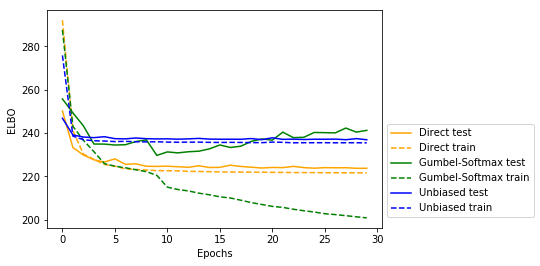

In [12]:

utils.show_and_save_plots([[(tr_dr,te_dr),'Direct'],
                           [(tr_gsm,te_gsm),'Gumbel-Softmax'],
                           [(tr_unb,te_unb),'Unbiased']])

### Inference

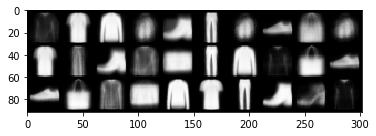

In [21]:
import torchvision

onehots = torch.eye(K)

out_unbiased = torch.sigmoid(decoder_unbiased(onehots)).view(-1,1,28,28)
out_direct = torch.sigmoid(decoder_direct(onehots)).view(-1,1,28,28)
out_gsm = torch.sigmoid(decoder_gsm(onehots)).view(-1,1,28,28)
out = torch.cat((out_unbiased,out_direct,out_gsm))

out=torchvision.utils.make_grid(out,nrow=K)
utils.show(out)


                                                  Decoder evaluations

|---|   unbiased   | direct  | GSM |
|:---:|:---:|:---:|:---:|
|forward|  $k$ |  $k+1$  |  $1$  |
|backward|  $k$  |  $1$  |  $1$  |
    
The table shows the number of the decoder evaluations (per 1 sample). For cells that are valued at >1, the evaluations are computed in batches. For the forward/direct cell, $1$ is for the forward pass and $k$ is for the decoder evaluations that needed in order to compute the encoder gradients. These $k$ evaluations are offline in the sense that there is no need to store their gradients for backward pass.



                                                  Encoder operations
|---|unbiased | direct | GSM |
|:---:|:---:|:---:|:---:|
|forward|  $k$ (*Softmax* operation)  |  $k$ (*max* operation) |  $k$ (*Softmax* operation)  |
|backward|  $k$ (chain rule) |  $2$ (opt, direct) |  $k$ (chain rule)|

In this table we present the number of operations requried to compute $h(x)$. In case that the encoder is unstructured the *max* and *Softmax* operations have the same complexity, but when the encoder is structured the number of different assignments can grow exponentialy, and the *max* operation can be computed with much better complexity than *Softmax*.





# Structured latent space

So far we have discussed the case of a single discrete latent variable. In such case both max and argmax operations have roughly the same running time complexity. 

However, when $z$ is structured, solving a Softmax operation can be very hard and sometimes impossible because of the exponential assignments in the partition function $\sum_{\hat z \in \mathcal{Z}} e^{h(x,\hat z)}$. 

We were working on a structure of the form:
$$ h_\phi(x,z) = \sum_{i=1}^n h_i(x,z_i;\phi) + \sum_{i > j} h_{i,j}(x,z_i,z_j;\phi)$$

In order to compute Softmax operation of the energy function above, one should compute all possible assignments ($2^n$).
Instead, solving $\arg\max$ problems can be obtained by ILP solvers such as *CPLEX* or *max-flow*.

*max-flow* can deal only with positive potentials $h_{i,j}(x,z_i,z_j)$
*CPLEX* can solve any (positive and negative) $h_{i,j}(x,z_i,z_j)$ and by that the encoder captures positive and negative interactions between variables. However, it comes with the price of much longer wall-clock time.

By two such maximizations we can  get $z_{opt} \text{ and } z_{direct}$ and by that to estimate the encoder gradients with reasonable time complexity.

#### structured encoder
The encoder ($h_\phi(x,z)$) produces $2\cdot n + {n \choose2}$ units. 

$2\cdot n$ : $n$ binary variables as one-hot representation ($h_i$).

${n \choose2}$: interactions between pairs of variables ($h_{ij}$).

In order to solve the maximization problem via maxflow algorithm we need to force $h_{ij} \geq 0$, we do it by the softplus operation. 


In [14]:
class Structrued_Encoder(nn.Module):
    
    def __init__(self, x_dim=784, N=6,solver='maxflow'):
        super(Structrued_Encoder, self).__init__()
        self.all_pairs = utils.ncr(N,2)
        self.encoder = nn.Sequential(
            nn.Linear(x_dim,300),
            nn.ReLU(),
            nn.Linear(300,2*N + self.all_pairs))
        self.N = N
        self.solver=solver
        
    def forward(self, x):
        h_x = self.encoder(x)
        h_i, h_ij = h_x.split([2*self.N,self.all_pairs],dim=1)
        if self.solver=='maxflow':
            h_ij = F.softplus(h_ij) # force h_ij >= 0
        z,h_gamma = self.gumbel_perturbation(h_i,h_ij)
        return z,h_gamma

    
    def gumbel_perturbation(self,h_i,h_ij):
        """ Pertubes N binary variables and solves the argmax of the pairwise energy function.
            args:
                h_i: N potentials
                h_ij: N choose 2 potentials
            returns:
                z: N binary variables
                h: h_i and h_ij potentials """
                
        h_i = h_i.contiguous().view(-1,2)

        gumbel_noise = utils.sample_gumbel(h_i,standard_gumbel=True)
        h_i_gamma = h_i + gumbel_noise
        h =list(zip(h_i_gamma.view(-1,self.N,2),h_ij))
        if self.solver=='maxflow':
            z = utils.argmax_maxflow(h)
        elif self.solver=='cplex':
            z = utils.argmax_cplex(h)
        else: # none
            z = h_i_gamma.argmax(-1)
  

        return z, h



However, $z_{direct}$ requires enumerating over $f_\theta(x,z_i)$ which is also exponential. Therefore, we search for $z_{direct}$ in a sub-space. Here we have $n$ binary variables and the way we search for $z_{direct}$ is to start from the realization of $z_{opt}$ and to change one variable at a time while the rest are fixed.

In [15]:
def compute_structured_encoder_gradients(z_opt,h_gamma,ground_truth,models,epsilon=1.0):
    
    h_i,h_ij = zip(*h_gamma)    
    h_i = torch.cat(h_i)
    """

    z_opt: binary vector of size N (batch, N)
    h_g: h_i + gumbel (batch x N, 2)
    h_ij: h_ij  (batch , N choose 2)
    
    """
    encoder,decoder=models
    N = encoder.N
    K = 2
    z_hat = utils.z_hat(z_opt,h_i,N,K)
    gt_batch = ground_truth.repeat_interleave(N*K,0)
    f_tilda = decoder(z_hat)
    with torch.no_grad():
        f_tilda = F.binary_cross_entropy_with_logits(f_tilda,gt_batch,reduction='none').sum(-1)
    
    grad_h_i,grad_h_ij = utils.h_i_and_h_ij_grads(h_i,h_ij,f_tilda,z_opt,epsilon,encoder.solver)
    
    gradients = torch.cat((grad_h_i, grad_h_ij),-1)
    decoder.train()
    gradients = gradients*(1.0/epsilon)
    return torch.sum(gradients)

In [16]:
def train_structured(train_loader,models,optimizers):
    encoder,decoder=models
    encoder_opt,decoder_opt=optimizers
    kl_sum, elbo_sum = 0,0
    for i, (x, _) in enumerate(train_loader):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)

        

        # forward
        z,h_gamma = encoder(x)
        N=encoder.N

        out = decoder(F.one_hot(z,2).view(-1,N*2).float()) 
        # backward
        encoder_loss = compute_structured_encoder_gradients(z,h_gamma,x,models)
        decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum()
        
        h_i,h_ij = zip(*h_gamma)
        kl = utils.kl_multinomial(torch.cat(h_i).view(-1,2))
        #kl = utils.kl_multinomial(h_x[:,:N].contiguous().view(-1,N))

        encoder_opt.zero_grad()
        decoder_opt.zero_grad()

        decoder_loss.backward()
        encoder_loss.backward()

        decoder_opt.step()
        encoder_opt.step()
        elbo = (decoder_loss+kl)/batch_size
        elbo_sum += elbo.detach().item()
        if i%100 == 0:
            print (elbo)
    elbo = elbo_sum/len(train_loader)

    return elbo

In [17]:
def evaluate_structured(test_loader,models):
    encoder,decoder=models
    encoder.eval()
    decoder.eval()
    elbo_sum =0    
    with torch.no_grad():
        for x, _ in test_loader:        
            x = x.view(x.size(0), -1)

            bs = x.size(0)

            # forward
            z,h_gamma = encoder(x)
            N=encoder.N

            out = decoder(F.one_hot(z,2).view(-1,N*2).float()) 
            # backward
            encoder_loss = compute_structured_encoder_gradients(z,h_gamma,x,models)

            decoder_loss  = F.binary_cross_entropy_with_logits(out,x,reduction='none').sum()
            h_i,h_ij = zip(*h_gamma)
            kl = utils.kl_multinomial(torch.cat(h_i).view(-1,2))


            elbo_sum += ((decoder_loss+kl)/bs).detach().item()

    encoder.train()
    decoder.train()

    elbo_test = elbo_sum/len(test_loader)
    return elbo_test

In [18]:

n=15
strc_encoder = Structrued_Encoder(N=n,solver='maxflow')
strc_decoder = Decoder(x_dim=x_dim,K=2*n)

opt_enc_strc = torch.optim.Adam(strc_encoder.parameters(), lr=0.001)
opt_dec_strc = torch.optim.Adam(strc_decoder.parameters(), lr=0.001)

models_strc = strc_encoder,strc_decoder
opt_strc = opt_enc_strc,opt_dec_strc

unstrc_encoder = Structrued_Encoder(N=n,solver='none')
unstrc_decoder = Decoder(x_dim=x_dim,K=2*n)

opt_enc_unstrc = torch.optim.Adam(unstrc_encoder.parameters(), lr=0.001)
opt_dec_unstrc = torch.optim.Adam(unstrc_decoder.parameters(), lr=0.001)

models_unstrc = unstrc_encoder,unstrc_decoder
opt_unstrc = opt_enc_unstrc,opt_dec_unstrc

strc_elbo,unstrc_elbo=[],[]
for t in range(30):
    train_strc=train_structured(train_loader,models_strc,opt_strc)
    eval_strc =evaluate_structured(test_loader,models_strc)
    strc_elbo.append((train_strc,eval_strc))

    train_unstrc=train_structured(train_loader,models_unstrc,opt_unstrc)
    eval_unstrc =evaluate_structured(test_loader,models_unstrc)
    unstrc_elbo.append((train_unstrc,eval_unstrc))
    print ('unstructure: {:.2f}, structure: {:.2f}'.format(eval_unstrc,eval_strc))


tensor(553.1064, grad_fn=<DivBackward0>)
tensor(335.3923, grad_fn=<DivBackward0>)
tensor(336.4720, grad_fn=<DivBackward0>)
tensor(311.2534, grad_fn=<DivBackward0>)
tensor(310.1214, grad_fn=<DivBackward0>)
tensor(299.4142, grad_fn=<DivBackward0>)
tensor(554.6033, grad_fn=<DivBackward0>)
tensor(337.5929, grad_fn=<DivBackward0>)
tensor(310.9660, grad_fn=<DivBackward0>)
tensor(328.0053, grad_fn=<DivBackward0>)
tensor(310.7096, grad_fn=<DivBackward0>)
tensor(321.3106, grad_fn=<DivBackward0>)
unstructure: 302.51, structure: 302.60
tensor(302.8212, grad_fn=<DivBackward0>)
tensor(302.1602, grad_fn=<DivBackward0>)
tensor(282.7755, grad_fn=<DivBackward0>)
tensor(282.1366, grad_fn=<DivBackward0>)
tensor(284.8661, grad_fn=<DivBackward0>)
tensor(288.9514, grad_fn=<DivBackward0>)
tensor(302.4470, grad_fn=<DivBackward0>)
tensor(289.9345, grad_fn=<DivBackward0>)
tensor(287.8660, grad_fn=<DivBackward0>)
tensor(303.0390, grad_fn=<DivBackward0>)
tensor(289.5636, grad_fn=<DivBackward0>)
tensor(301.1740, g

tensor(260.1761, grad_fn=<DivBackward0>)
tensor(271.0323, grad_fn=<DivBackward0>)
tensor(268.1201, grad_fn=<DivBackward0>)
tensor(268.3369, grad_fn=<DivBackward0>)
tensor(245.0291, grad_fn=<DivBackward0>)
tensor(247.1990, grad_fn=<DivBackward0>)
unstructure: 263.12, structure: 259.17
tensor(251.8946, grad_fn=<DivBackward0>)
tensor(240.9190, grad_fn=<DivBackward0>)
tensor(255.4265, grad_fn=<DivBackward0>)
tensor(260.3126, grad_fn=<DivBackward0>)
tensor(259.6820, grad_fn=<DivBackward0>)
tensor(238.4711, grad_fn=<DivBackward0>)
tensor(259.8651, grad_fn=<DivBackward0>)
tensor(265.8708, grad_fn=<DivBackward0>)
tensor(272.9797, grad_fn=<DivBackward0>)
tensor(272.8145, grad_fn=<DivBackward0>)
tensor(264.7982, grad_fn=<DivBackward0>)
tensor(250.0512, grad_fn=<DivBackward0>)
unstructure: 262.65, structure: 258.07
tensor(253.6975, grad_fn=<DivBackward0>)
tensor(248.7142, grad_fn=<DivBackward0>)
tensor(241.8101, grad_fn=<DivBackward0>)
tensor(256.6730, grad_fn=<DivBackward0>)
tensor(260.8153, gra

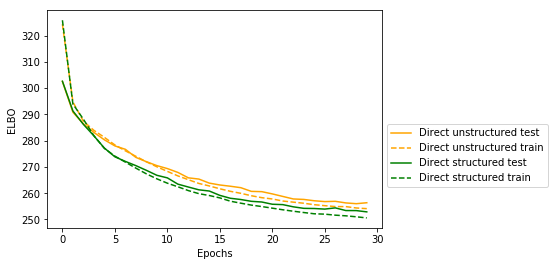

In [19]:
tr_str,te_str=zip(*strc_elbo)
tr_unstr,te_unstr=zip(*unstrc_elbo)
utils.show_and_save_plots([[(tr_unstr,te_unstr),'Direct unstructured'],
                           [(tr_str,te_str),'Direct structured']])

# Inference

torch.Size([30, 30])


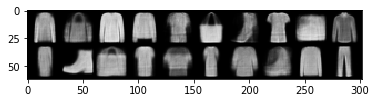

In [43]:
import torchvision
import numpy as np


z=torch.tensor([np.random.choice([0, 1], size=(n,), p=[1./3, 2./3]) for _ in range(10)])
z=F.one_hot(z).float().view(z.size(0),-1)
out_strc = F.sigmoid(strc_decoder(z)).view(-1,1,28,28)
out_unst = F.sigmoid(unstrc_decoder(z)).view(-1,1,28,28)

to_show = torch.cat((out_strc,out_unst))
out_strc=torchvision.utils.make_grid(to_show,nrow=10)
utils.show(out_strc)



                                                Decoder evaluations

|---|   unbiased   | direct  | GSM |
|:---:|:---:|:---:|:---:|
|forward|  $2^n$ |  $n+1$ (input size: $n + {n\choose 2}$) |  $1$ (input size: $2^n$)  |
|backward|  $2^n$  |  $ 1 $  | $1$ (input size: $2^n$)  |
    
*Gumbel-Softmax* is an end-to-end approach which is a major advantage, however, in order to compute *Softmax* one should evaluate $h_\phi(x,z)$ for all $z$ realizations which makes it unfeasable (for about $n \ge 15$).

In *Direct-Gumbel-Max* we look for the *$\arg\max$* that can be found more efficiently than *Softmax*. However, we need to search for $z_{direct}$ in an exponential space. Instead, we search in a sub-space. In forward/direct cell, $1$ is for the forward pass and $n$ for the forward pass when computing $z_{direct}$. These $n$ evaluations are offline in a sense that there is no need to store their gradients for backward pass.


                                                Encoder operations

|---|   unbiased   | direct  | GSM |
|:---:|:---:|:---:|:---:|
|forward|  $2^n$ (*softmax* operation)  |  ILP solver complexity  |  $2^n$ (*softmax* operation)  |
|backward|  $2^n$ (chain rule) |  $2 \times$ solver complexity (opt, direct) |  $2^n$ (chain rule)|


# References

[1] Diederik P Kingma, Max Welling. “Auto-Encoding Variational Bayes.” ICLR, 2014.

[2] Chris J. Maddison, Andriy Mnih, and Yee Whye Teh. “The Concrete Distribution: a Continuous Relaxation of Discrete Random Variables.” ICLR, 2017.

[3] Eric Jang, Shixiang Gu and Ben Poole. “Categorical Reparameterization by Gumbel-Softmax.” ICLR, 2017.

[4] D.McAllester, T. Hazan, and J. Keshet. "Direct loss minimization for structured prediction." NIPS, 2010.

[5] Y. Song, A. G. Schwing, R. Zemel, and R. Urtasun. "Training Deep Neural Networks via DirectLoss Minimization." ICML, 2016.

[6] Danilo Jimenez Rezende, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagationand approximate inference in deep generative models." ICML, 2014.

[7] Jordan, M.I. and Ghahramani, Z. and Jaakkola, T.S. and Saul, L.K. "An introduction to variational methods for graphical models." 

